# Проект: Обучение с учителем: качество модели

В рамках данного проекта предстоит разработать решение, которое позволит персонализировать предложения постоянным клиентам интернет-магазина «В один клик», чтобы увеличить их покупательскую активность.

Задачи:

1.Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

2.Нужно собрать данные по клиентам.

3.Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

4.В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

5.Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

План работы:

- Изучить информацию о датафреймах;

- Сделать предобработку данных;

- Сделать исследовательский анализ данных;

- Объединить таблицы;

- Провести корреляционный анализ признаков;

- Использовать пайплайны;

- Проанализировать важность признаков;

- Сделать сегментацию покупателей;

- Сделать выводы.

Описание данных: 

- market_file.csv -таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
id — номер покупателя в корпоративной базе данных.

Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


- market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

Выручка — сумма выручки за период.

- market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксировано общее время.

минут — значение времени, проведённого на сайте, в минутах.

- money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

id — номер покупателя в корпоративной базе данных.

Прибыль — значение прибыли.

In [1]:
!pip install scikit-learn==1.1.0 -q
!pip install matplotlib==3.5.1 -q
!pip install shap 
!pip install phik

import os
import numpy as np
import pandas as pd
import seaborn as sns
import shap

import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
)
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

RANDOM_STATE = 42

## Загрузка данных

In [2]:
pth1 = '/datasets/market_file.csv'
pth2 = 'https://code.s3.yandex.net/datasets/market_file.csv'

if os.path.exists(pth1):
    data_market = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_market = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(data_market.head())
data_market.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [3]:
pth3 = '/datasets/market_money.csv'
pth4 = 'https://code.s3.yandex.net/datasets/market_money.csv'

if os.path.exists(pth3):
    data_market_money = pd.read_csv(pth3)
elif os.path.exists(pth4):
    data_market_money = pd.read_csv(pth4)
else:
    print('Something is wrong')
    
display(data_market_money.head())
data_market_money.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [4]:
pth5 = '/datasets/market_time.csv'
pth6 = 'https://code.s3.yandex.net/datasets/market_time.csv'

if os.path.exists(pth5):
    data_time = pd.read_csv(pth5)
elif os.path.exists(pth6):
    data_time = pd.read_csv(pth6)
else:
    print('Something is wrong')
    
display(data_time.head())
data_time.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [5]:
pth7 = '/datasets/money.csv'
pth8 = 'https://code.s3.yandex.net/datasets/money.csv'

if os.path.exists(pth7):
    data_money = pd.read_csv(pth7, sep = ';', decimal = ',')
elif os.path.exists(pth8):
    data_money = pd.read_csv(pth8, sep = ';', decimal = ',')
else:
    print('Something is wrong')
    
display(data_money.head())
data_money.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Выводы:

В датафрейме data_market 1300 записей, названия столбцов адекватны содержащимся в них данным, но введены на кириллице, в столбцах id, Маркет_актив_тек_мес, Длительность, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Ошибка_сервиса, Страниц_за_визит тип данных int, в столбцах Покупательская активность, Тип сервиса, Разрешить сообщать, Популярная_категория тип данных object, в столбцах Маркет_актив_6_мес, Акционные_покупки тип данных  float.

В датафрейме data_market_money 3900 записи, названия столбцов адекватны содержащимся в них данным, но введены на кириллице, в столбцах id тип данных int, в столбце Период тип данных object, в столбце Выручка float.

В датафрейме data_time 2600 записей, названия столбцов адекватны содержащимся в них данным, но введены на кириллице,  в столбцах id тип данных int, в столбце Период тип данных object, в столбце минут float.

В датафрейме data_money 1300 записей, названия столбцов адекватны содержащимся в них данным, но введены на кириллице,  в столбцах id тип данных int, в столбце Прибыль float.

Требуется коректировка названий столбцов и предобработка данных (проверка наличия пропусков и дубликатов).

##  Предобработка данных

In [6]:
# приведем в порядок названия столбцов
data_market.rename(
    columns={
        'Покупательская активность':'purchasing_activity',
        'Тип сервиса':'type_of_service',
        'Разрешить сообщать':'allow_reporting',
        'Маркет_актив_6_мес':'market_active_6_months',
        'Маркет_актив_тек_мес':'market_active_cur_mon',
        'Длительность':'duration',
        'Акционные_покупки':'promotional_purchases',
        'Популярная_категория':'popular_category',
        'Средний_просмотр_категорий_за_визит':'average_view_category_visit',
        'Неоплаченные_продукты_штук_квартал':'unpaid_product_stack_quart',
        'Ошибка_сервиса':'service_error',
        'Страниц_за_визит':'page_visit'
    },
    inplace=True
)

In [7]:
data_market_money.rename(
    columns={
        'Период':'period',
        'Выручка':'revenue'
    },
    inplace=True
)

In [8]:
data_time.rename(
    columns={
        'Период':'period',
        'минут':'minutes'
    },
    inplace=True
)

In [9]:
data_money.rename(
    columns={
        'Период':'period',
        'Прибыль':'profit'
    },
    inplace=True
)

In [10]:
# проверяем замены в названиях
display(data_market.head())

,id,purchasing_activity,type_of_service,allow_reporting,market_active_6_months,market_active_cur_mon,duration,promotional_purchases,popular_category,average_view_category_visit,unpaid_product_stack_quart,service_error,page_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [11]:
display(data_market_money.head())

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [12]:
display(data_time.head())

,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [13]:
display(data_money.head())

,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [14]:
# проверяем наличие пропущенных значений в датафреймах
data_market.isna().sum()

id                             0
purchasing_activity            0
type_of_service                0
allow_reporting                0
market_active_6_months         0
market_active_cur_mon          0
duration                       0
promotional_purchases          0
popular_category               0
average_view_category_visit    0
unpaid_product_stack_quart     0
service_error                  0
page_visit                     0
dtype: int64

In [15]:
data_market_money.isna().sum()

id         0
period     0
revenue    0
dtype: int64

In [16]:
data_time.isna().sum()

id         0
period     0
minutes    0
dtype: int64

In [17]:
data_money.isna().sum()

id        0
profit    0
dtype: int64

In [18]:
# проверяем наличие явных дубликатов в датафреймах
data_market.duplicated().sum()

0

In [19]:
data_market_money.duplicated().sum()

0

In [20]:
data_time.duplicated().sum()

0

In [21]:
data_money.duplicated().sum()

0

In [22]:
# проверяем значения в столбцах
data_market['type_of_service'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [23]:
data_market['type_of_service'] = data_market['type_of_service'].replace('стандартт', 'стандарт')

In [24]:
data_market['type_of_service'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [25]:
data_market_money['period'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [26]:
data_time['period'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [27]:
data_time['period'] = data_time['period'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [28]:
data_time['period'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [29]:
# убираем заглавные буквы
data_market.columns = data_market.columns.str.lower()
data_market_money.columns = data_market_money.columns.str.lower()
data_time.columns = data_time.columns.str.lower()
data_money.columns = data_money.columns.str.lower()

In [30]:
data_market.shape

(1300, 13)

In [31]:
data_market_money.shape

(3900, 3)

In [32]:
data_time.shape

(2600, 3)

In [33]:
data_money.shape

(1300, 2)

Выводы:

Были изменены названия столбцов;

Проверено, нет ли пропущенных значений;

Было проверено наличие явных дубликатов;

Данные готовы к исследовательскому анализу.

## Исследовательский анализ данных

In [34]:
# отберём покупателей, которые совершали покупки за последние три месяца
id_clients = data_market_money.loc[data_market_money['revenue'] == 0, 'id'].unique()
data_money = data_money[~data_money['id'].isin(id_clients)]
data_market_money = data_market_money.loc[~data_market_money['id'].isin(id_clients), :]
data_market = data_market.loc[~data_market['id'].isin(id_clients), :]
data_time = data_time.loc[~data_time['id'].isin(id_clients), :]

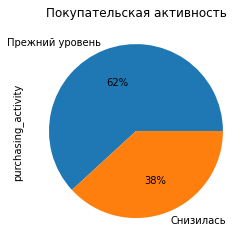

In [35]:
# проведем статистический анализ всех данных
data_market['purchasing_activity'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Покупательская активность')
plt.show()

У 38% id снизилась покупательская активность.

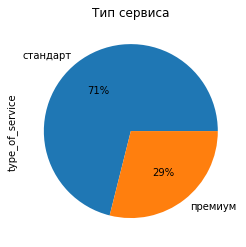

In [36]:
data_market['type_of_service'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Тип сервиса')
plt.show()

У 71% id - тип сервиса "стандарт".

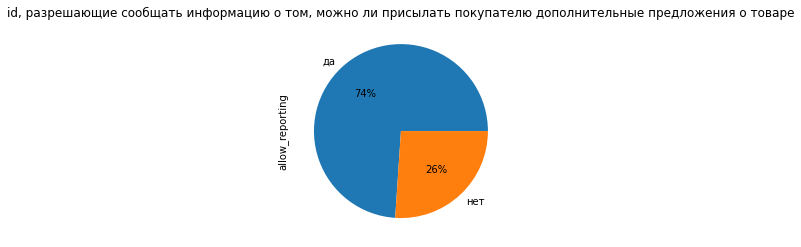

In [37]:
data_market['allow_reporting'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', 
    title = 'id, разрешающие сообщать информацию о том, можно ли присылать покупателю дополнительные предложения о товаре')
plt.show()

74% id разрешают сообщать информацию о том, можно ли присылать покупателю дополнительные предложения о товаре.

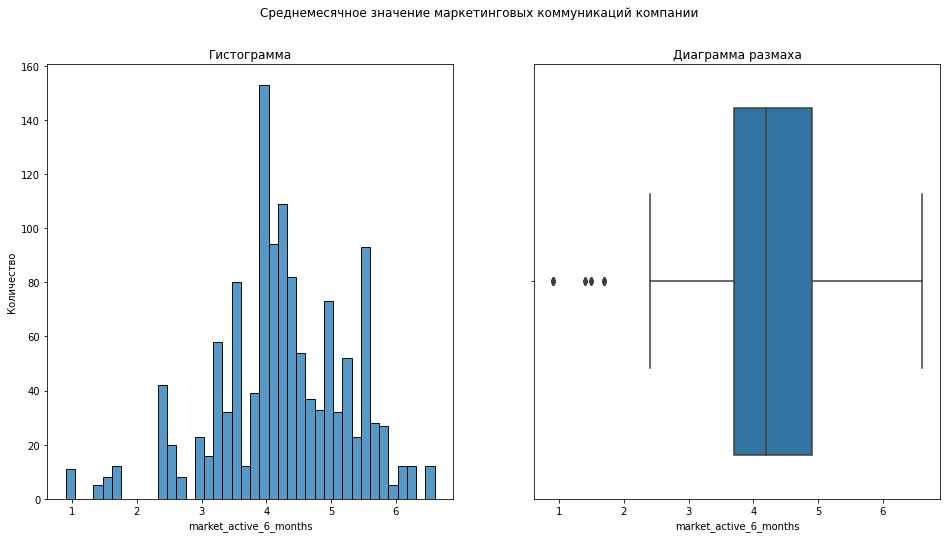

In [38]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market,x = 'market_active_6_months', ax=axs[0], bins = 40)
axs[0].set_xlabel('market_active_6_months')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market,x = 'market_active_6_months', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Среднемесячное значение маркетинговых коммуникаций компании')
plt.show()

In [39]:
data_market['market_active_6_months'].describe()

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: market_active_6_months, dtype: float64

Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, находятся в диапазоне от 0.9 до 6.6, медиана - 4.2.

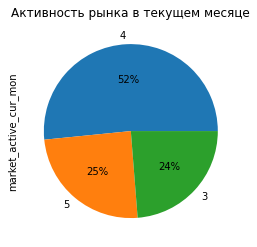

In [40]:
data_market['market_active_cur_mon'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Активность рынка в текущем месяце')
plt.show()

 Количество маркетинговых коммуникаций в текущем месяце - 4 у 52%, 5 у 25%  и 3 у 24%.

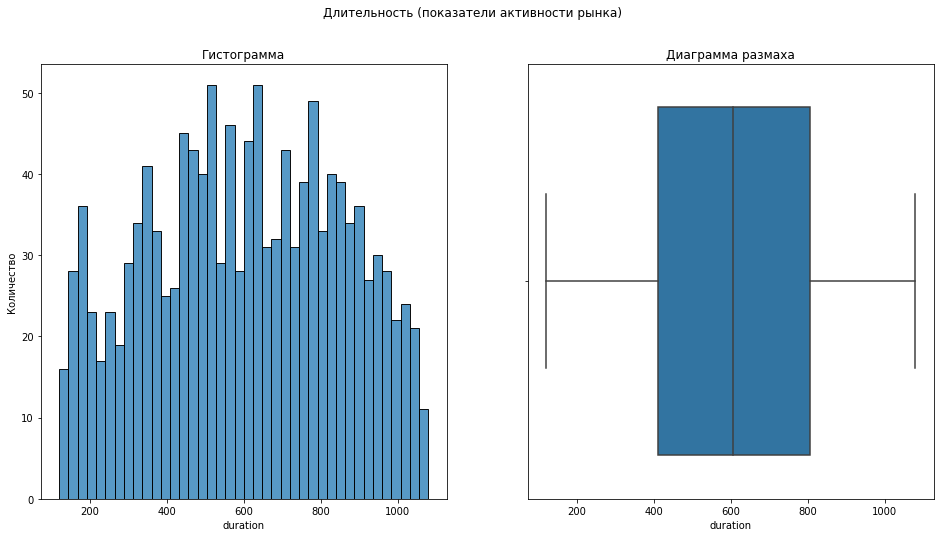

In [41]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market,x = 'duration', ax=axs[0], bins = 40)
axs[0].set_xlabel('duration')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market,x = 'duration', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Длительность (показатели активности рынка)')
plt.show()

In [42]:
data_market['duration'].describe()

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64

Показатели активности рынка находятся в диапазоне от 110 до 1079, медиана - 607.

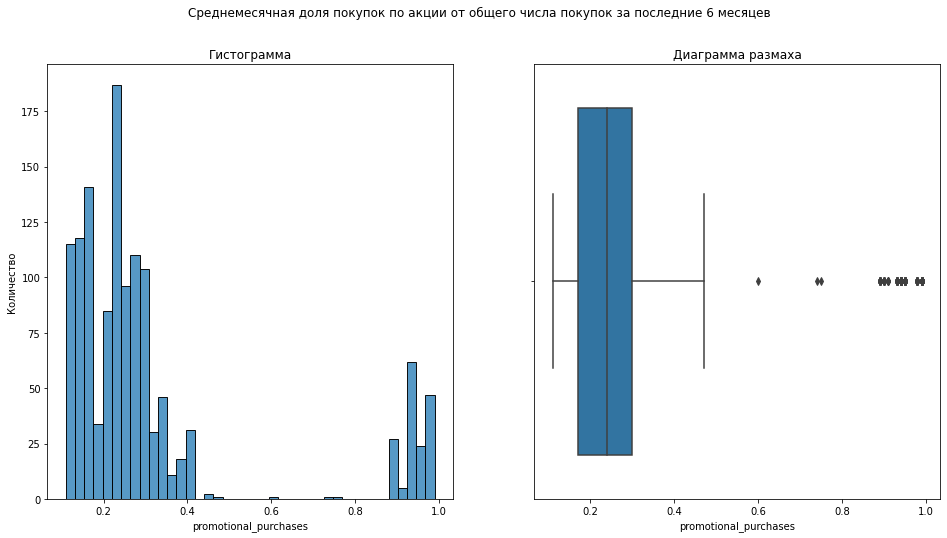

In [43]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market,x = 'promotional_purchases', ax=axs[0], bins = 40)
axs[0].set_xlabel('promotional_purchases')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market,x = 'promotional_purchases', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.show()

In [44]:
data_market['promotional_purchases'].describe()

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promotional_purchases, dtype: float64

Показатели среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев находятся в диапазоне от 0 до 0.99, медиана - 0.24.

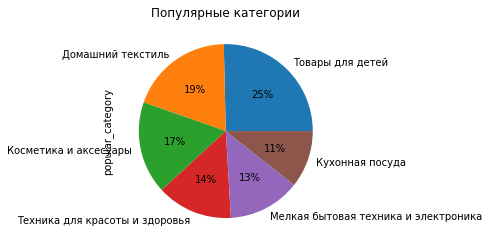

In [45]:
data_market['popular_category'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Популярные категории')
plt.show()

Популярные категории: товары для детей (26%), домашний текстиль (19%), косметика и аксесуары (17%), техника для красоты и здоровья (14%), мелкая бытовая техника и электроника (14%), кухонная посуда (11%).

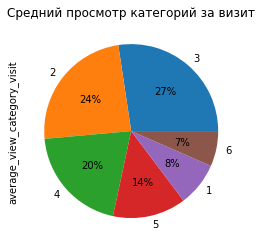

In [46]:
data_market['average_view_category_visit'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Средний просмотр категорий за визит')
plt.show()

Средний просмотр категорий за визит: 3 (27%), 2 (24%), 4 (21%).

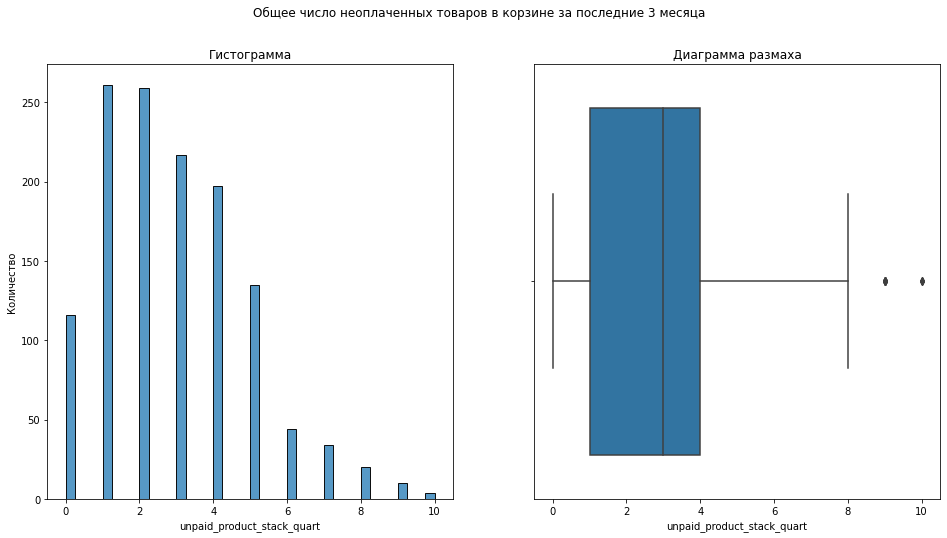

In [47]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market,x = 'unpaid_product_stack_quart', ax=axs[0], bins = 40)
axs[0].set_xlabel('unpaid_product_stack_quart')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market,x = 'unpaid_product_stack_quart', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Общее число неоплаченных товаров в корзине за последние 3 месяца')
plt.show()

In [48]:
data_market['unpaid_product_stack_quart'].describe()

count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_product_stack_quart, dtype: float64

Общее число неоплаченных товаров в корзине за последние 3 месяца - от 0 до 10, медиана - 2.

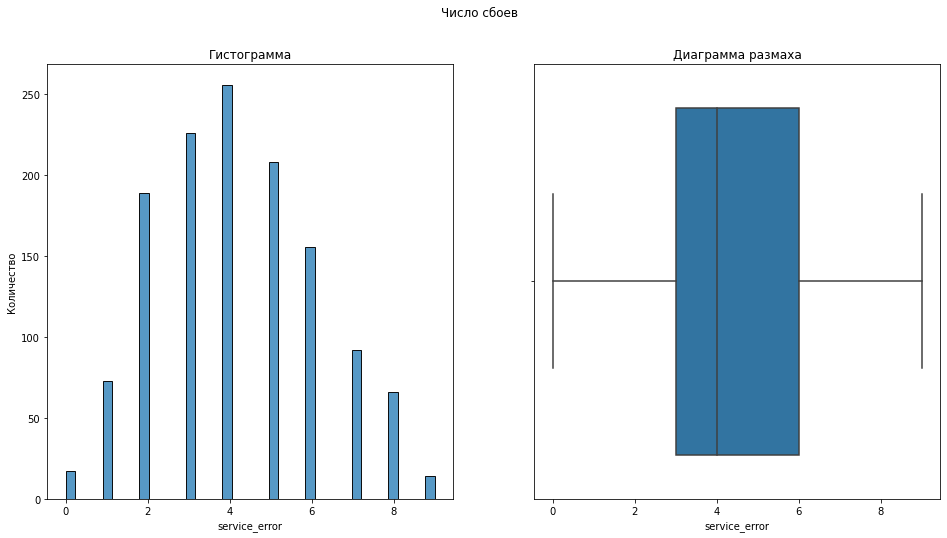

In [49]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market,x = 'service_error', ax=axs[0], bins = 40)
axs[0].set_xlabel('service_error')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market,x = 'service_error', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Число сбоев')
plt.show()

In [50]:
data_market['service_error'].describe()

count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: service_error, dtype: float64

Число сбоев, которые коснулись покупателя во время посещения сайта - от 0 до 9, медиана - 4.

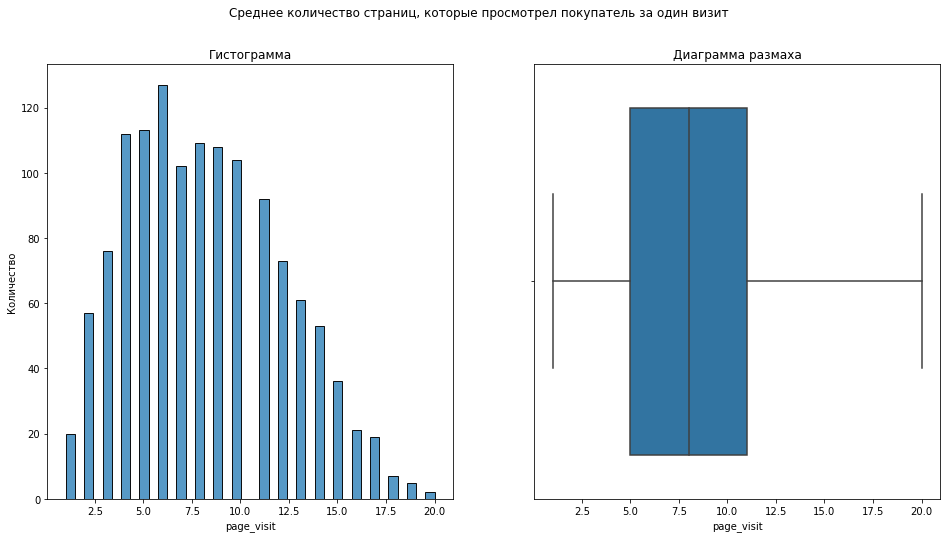

In [51]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market,x = 'page_visit', ax=axs[0], bins = 40)
axs[0].set_xlabel('page_visit')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market,x = 'page_visit', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Среднее количество страниц, которые просмотрел покупатель за один визит')
plt.show()

In [52]:
data_market['page_visit'].describe()

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: page_visit, dtype: float64

Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца: от 1 до 20, медиана - 8.

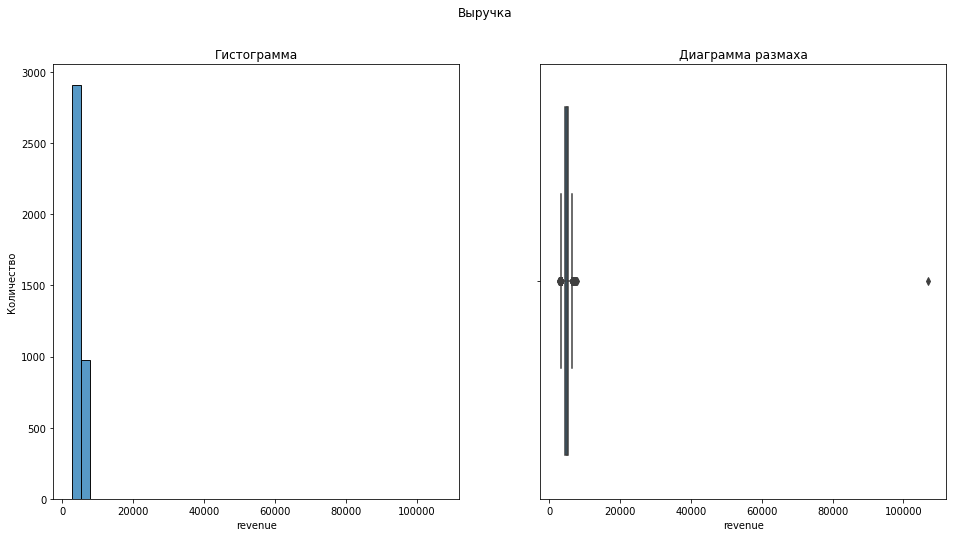

In [53]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market_money,x = 'revenue', ax=axs[0], bins = 40)
axs[0].set_xlabel('revenue')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market_money,x = 'revenue', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Выручка')
plt.show()

In [54]:
# удаляем выброс
data_market_money = data_market_money.query('revenue < 20000')

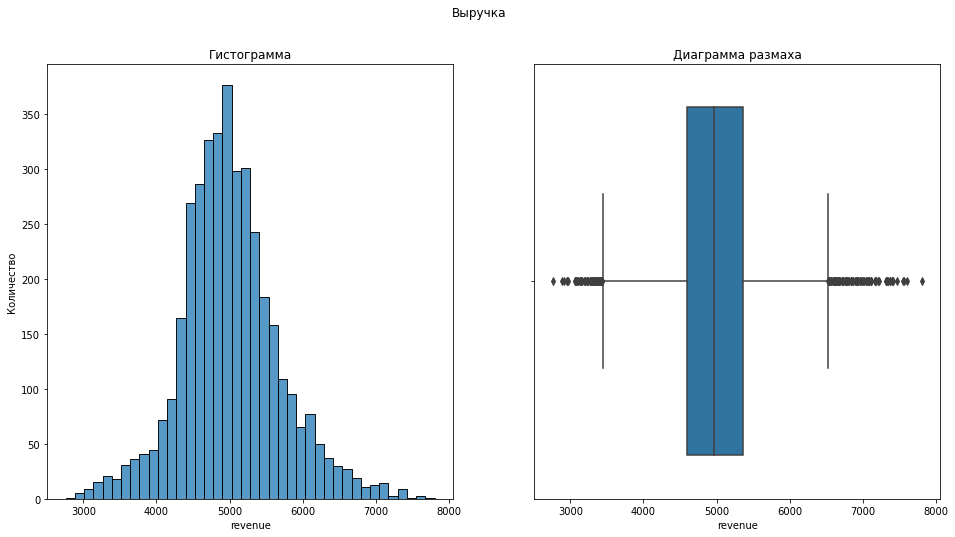

In [55]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_market_money,x = 'revenue', ax=axs[0], bins = 40)
axs[0].set_xlabel('revenue')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_market_money,x = 'revenue', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Выручка')
plt.show()

In [56]:
data_market_money['revenue'].describe()

count    3890.000000
mean     5007.541902
std       679.235737
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: revenue, dtype: float64

Сумма выручки за период от  0 до 7799, медиана - 4959. 

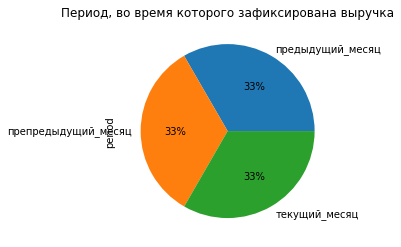

In [57]:
data_market_money['period'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Период, во время которого зафиксирована выручка')
plt.show()

33% выручки получено в предыдущем месяце и 33% - в текущем.

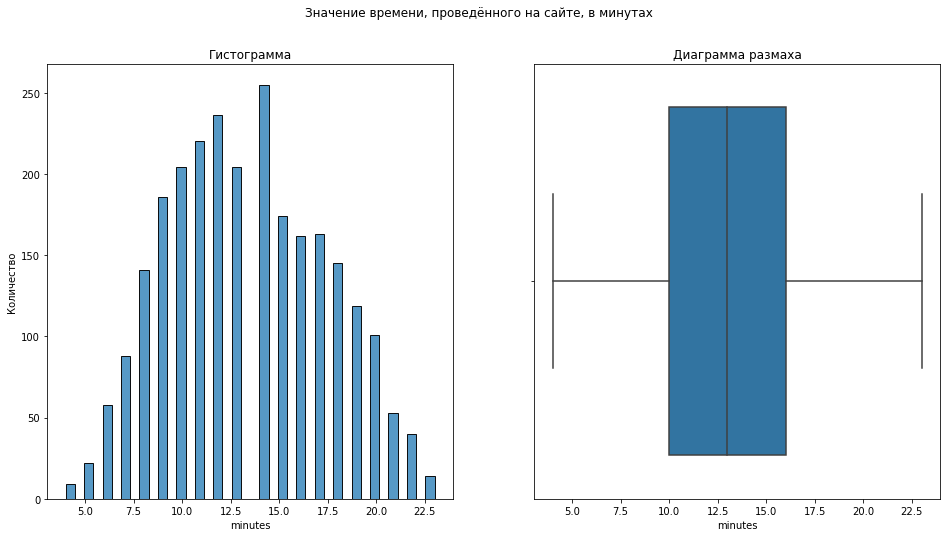

In [58]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_time,x = 'minutes', ax=axs[0], bins = 40)
axs[0].set_xlabel('minutes')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_time,x = 'minutes', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Значение времени, проведённого на сайте, в минутах')
plt.show()

In [59]:
data_time['minutes'].describe()

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64

Значение времени, проведённого на сайте, в минутах - от 4 до 23, медиана - 13.

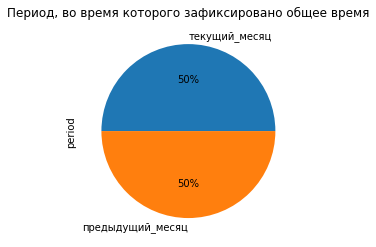

In [60]:
data_time['period'].value_counts().plot(
    y = 'count', kind = 'pie', autopct='%1.0f%%', title = 'Период, во время которого зафикcировано общее время')
plt.show()

Периоды, во время которых зафискировано общее время, - 50% в текущем месяце и 50% в предыдущем.

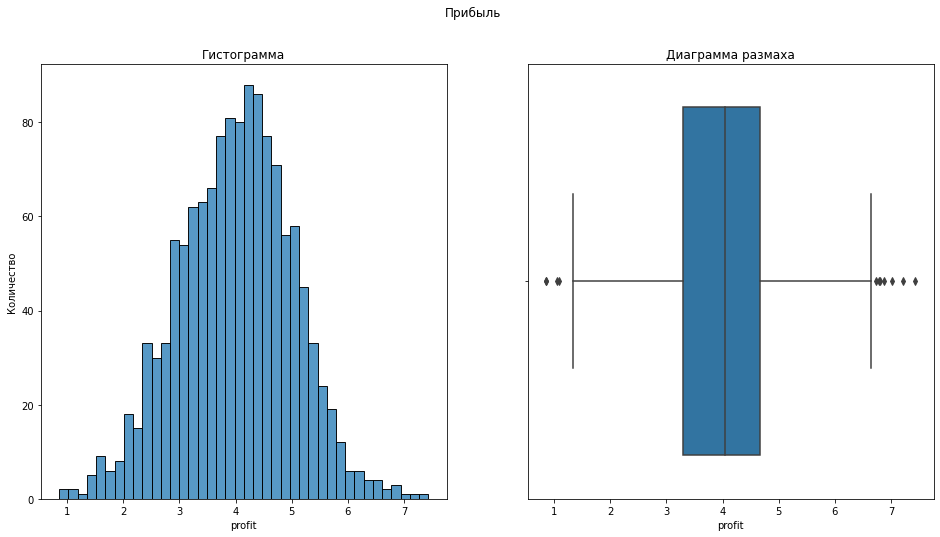

In [61]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
sns.histplot(data = data_money,x = 'profit', ax=axs[0], bins = 40)
axs[0].set_xlabel('profit')
axs[0].set_ylabel('Количество')
axs[0].set_title('Гистограмма')
sns.boxplot(data = data_money,x = 'profit', ax=axs[1])
axs[1].set_title('Диаграмма размаха')
fig.suptitle('Прибыль')
plt.show()

In [62]:
data_money['profit'].describe()

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

Значение прибыли за последние 3 месяца - от 0.86 до 7.43, медиана - 4.04.

Выводы:

Только у 38% id снизилась покупательская активность. У 71% id - тип сервиса "стандарт". 74% id разрешают сообщать информацию о том, можно ли присылать покупателю дополнительные предложения о товаре. Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, находятся в диапазоне от 0.9 до 6.6, медиана - 4.2.Количество маркетинговых коммуникаций в текущем месяце - 4 у 52%, 5 у 25% и 3 у 24%. Показатели активности рынка находятся в диапазоне от 110 до 1079, медиана - 607. Показатели активности рынка находятся в диапазоне от 0 до 0.99, медиана - 0.24. Популярные категории: товары для детей (26%), домашний текстиль (19%), косметика и аксесуары (17%), техника для красоты и здоровья (14%), мелкая бытовая техника и электроника (14%), кухонная посуда (11%). Средний просмотр категорий за визит: 3 (27%), 2 (24%), 4 (21%). Общее число неоплаченных товаров в корзине за последние 3 месяца - от 0 до 10, медиана - 2. Число сбоев, которые коснулись покупателя во время посещения сайта, - от 0 до 9, медиана - 4. Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. - от 1 до 20, медиана - 8. Сумма выручки за период от 0 до 7799, медиана - 4959.. 67% выручки получено в предыдущем месяце и 33% - в текущем. Значение времени, проведённого на сайте, в минутах - от 4 до 23, медиана - 13. Периоды, во время которых зафискировано общее время, - 50% в текущем месяце и 50% в предыдущем. Значение прибыли за последние 3 месяца - от 0.86 до 7.43, медиана - 4.04.

## Объединение таблиц

In [63]:
# объединим все датасеты в одну таблицу
data_market_money_new = data_market_money.pivot_table(
    index='id', columns='period', values='revenue', aggfunc='first').reset_index()
data_market_money_new.columns.name = None

In [64]:
data_market_money_new = data_market_money_new.rename(
    columns = {'id':'id', 'предыдущий_месяц': 'revenue_last_month', 'текущий_месяц': 'revenue_current_month', 
               'препредыдущий_месяц':'revenue_before_last_month'})

In [65]:
data_market_money_new.head()

,id,revenue_last_month,revenue_before_last_month,revenue_current_month
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [66]:
data_time_new = data_time.pivot_table(index='id', columns='period', values='minutes', aggfunc='first').reset_index()
data_time_new.columns.name = None  
data_time_new = data_time_new.rename(
    columns={'id': 'id', 'предыдущий_месяц': 'minutes_last_month', 'текущий_месяц': 'minutes_current_month'})

In [67]:
data = pd.merge(data_market, data_market_money_new, on='id')
data.head()

,id,purchasing_activity,type_of_service,allow_reporting,market_active_6_months,market_active_cur_mon,duration,promotional_purchases,popular_category,average_view_category_visit,unpaid_product_stack_quart,service_error,page_visit,revenue_last_month,revenue_before_last_month,revenue_current_month
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5


In [68]:
data = pd.merge(data, data_time_new, on='id')
data.head()

,id,purchasing_activity,type_of_service,allow_reporting,market_active_6_months,market_active_cur_mon,duration,promotional_purchases,popular_category,average_view_category_visit,unpaid_product_stack_quart,service_error,page_visit,revenue_last_month,revenue_before_last_month,revenue_current_month,minutes_last_month,minutes_current_month
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [69]:
data = data.dropna()

In [70]:
data.set_index('id', inplace=True)

In [71]:
data.shape

(1296, 17)

In [72]:
data.head()

,purchasing_activity,type_of_service,allow_reporting,market_active_6_months,market_active_cur_mon,duration,promotional_purchases,popular_category,average_view_category_visit,unpaid_product_stack_quart,service_error,page_visit,revenue_last_month,revenue_before_last_month,revenue_current_month,minutes_last_month,minutes_current_month
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Выводы:

Данные из датасетов были объединены в одну таблицу.

## Корреляционный анализ

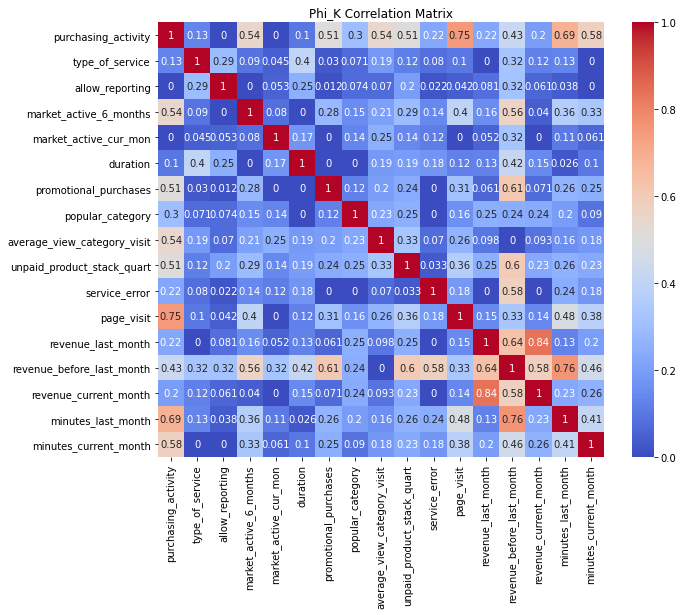

In [73]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = data.phik_matrix(
    interval_cols=['market_active_6_months', 'market_active_cur_mon', 
                   'duration', 'promotional_purchases', 'average_view_category_visit', 'unpaid_product_stack_quart', 
                   'service_error', 'page_visit', 'revenue_last_month', 
                   'revenue_current_month', 'minutes_last_month', 'minutes_current_month'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

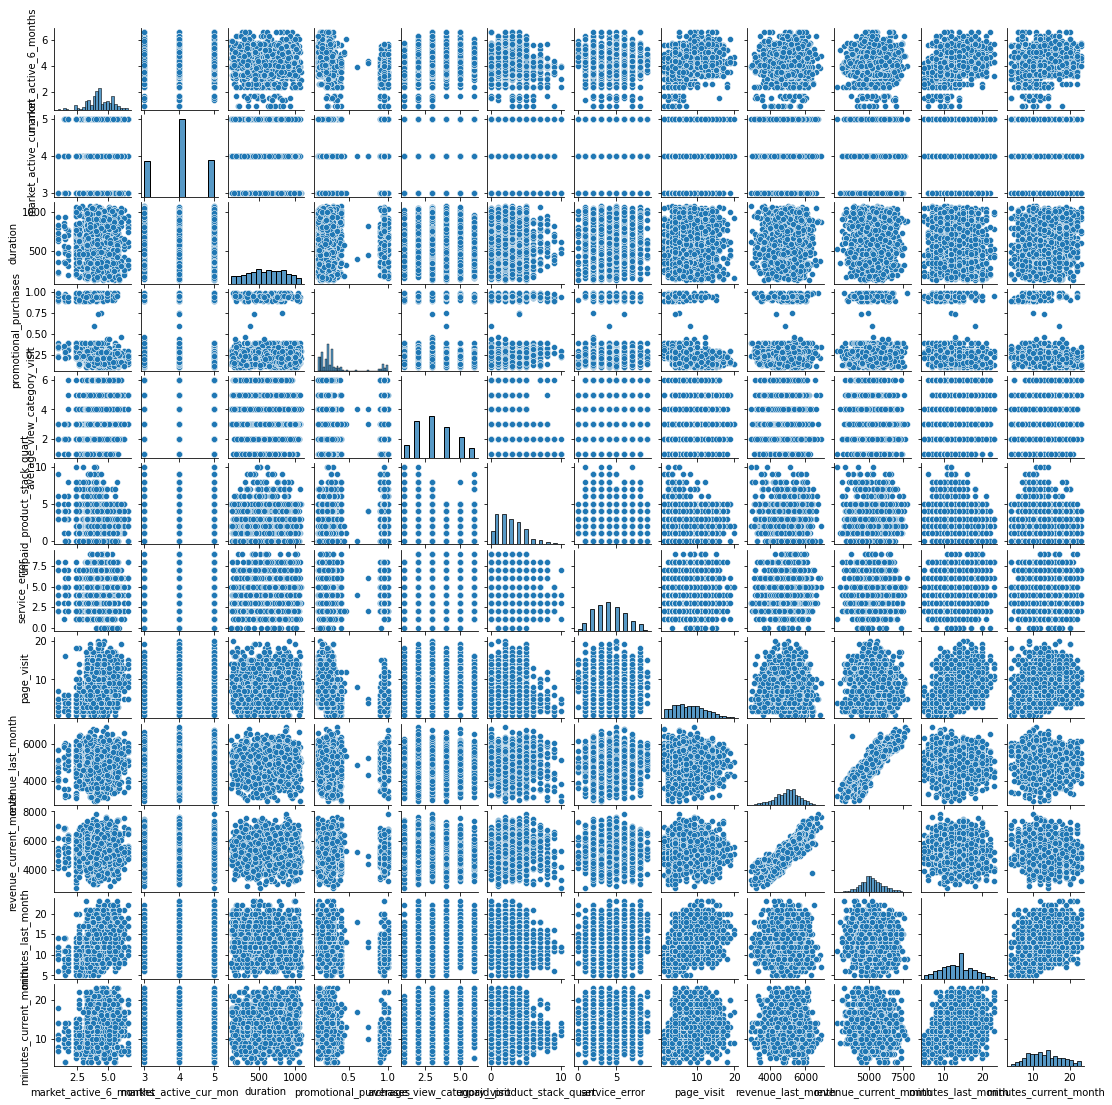

In [74]:
# изучим взаимосвязь между признаками: построим диаграммы рассеяния
sns.pairplot(data[['market_active_6_months', 'market_active_cur_mon', 
                   'duration', 'promotional_purchases', 'average_view_category_visit', 'unpaid_product_stack_quart', 
                   'service_error', 'page_visit', 'revenue_last_month', 
                   'revenue_current_month', 'minutes_last_month', 'minutes_current_month']])
plt.gcf().set_size_inches(15,15);


Выводы:

У покупательской активности высокая корреляция с количеством посещенных страниц (0.75), минутами за последний месяц (0.68). Нет мультиколлинеарности. 

##  Использование пайплайнов

In [75]:
# переведем покупательскую активность в категориальный признак, 1 - "снизилась", 0 - осталась без изменений
data['purchasing_activity'] = data['purchasing_activity'].apply(lambda x: 1 if x =='Снизилась' else 0)
data.head()

,purchasing_activity,type_of_service,allow_reporting,market_active_6_months,market_active_cur_mon,duration,promotional_purchases,popular_category,average_view_category_visit,unpaid_product_stack_quart,service_error,page_visit,revenue_last_month,revenue_before_last_month,revenue_current_month,minutes_last_month,minutes_current_month
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [76]:
# создадим списки с названиями признаков и разделим данные на обучающую и тестовую выборки
ohe_columns = ['allow_reporting', 'popular_category']
ord_columns = ['type_of_service']
num_columns = ['market_active_6_months', 'market_active_cur_mon', 'duration', 'promotional_purchases', 
               'average_view_category_visit', 'unpaid_product_stack_quart', 
                   'service_error', 'page_visit', 'revenue_last_month', 'revenue_before_last_month',
                   'revenue_current_month', 'minutes_last_month', 'minutes_current_month']

y = data['purchasing_activity']
X = data.drop(['purchasing_activity'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
) 

In [77]:
# экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [78]:
# пайплайн для кодирования категориальных признаков
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse =False)
        )
    ]
) 

In [79]:
# пайплайн для кодирования порядковых признаков
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [80]:
# объединяем все пайплайны с помощью ColumnTransformer
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [81]:
# итоговый пайплайн
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [82]:
# словари для моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC().
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
        'models__gamma': [0.01, 0.1, 1, 10],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 1000),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

In [83]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['allow_reporting',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                Simple...
                                         'models__degree': [2, 3, 4],
                                         'models__gamma': [0.01, 0.1, 1, 10],
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid', 'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(C=11,
                                                                       random_state=42)],
                                         'models__C': range(1, 1000),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [84]:
# определим наилучшую модель, найденную в процессе рандомизированного поиска
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['allow_reporting',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_freque...
                                                 ('num', StandardScaler(),
                                                  ['market_active_6_months',
                                                   'market_active_cur_mon',
                                                   'duration',
                                                   'promotional_purchases',
                                                   'average_view_category_visit',
                                                   'unpaid_product_stack_quart',
                                                   'service_error',
                                                   'page_visit',
                                                   'revenue_last_month',
                                                   'revenue_before_last_month',
                                                   'revenue_current_month',
                                                   'minutes_last_month',
                                                   'minutes_current_month'])])),
                ('models', LogisticRegression(C=11, random_state=42))])

In [85]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.8979465466825369


In [86]:
y_predict = randomized_search.predict(X_test)
y_predict_proba = randomized_search.predict_proba(X_test)

Используем метрику roc_auc, т.к. метрику можно использовать для оценки моделей с различными пороговыми значениями и для сравнения моделей с разными настройками

In [87]:
roc_auc_score(y_test, y_predict_proba[:, 1])

0.9025172358505692

Выводы:

Лучшая модель - LogisticRegression(C=11, random_state=42), значение метрики roc_auc - 0.9.

## Анализ важности признаков

In [88]:
# Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP
# преобразуем данные обучающей выборки
X_train_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

# создадим датафрейм для тестовых данных с именами признаков
X_test_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].transform(X_test), 
    columns= pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
model = LogisticRegression(C=11, random_state=42)
model.fit(X_train_shap, y_train)
explainer = shap.LinearExplainer(model, X_train_shap)
# посчитаем значения SHAP для тестовых данных
shap_values = explainer(X_test_shap)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


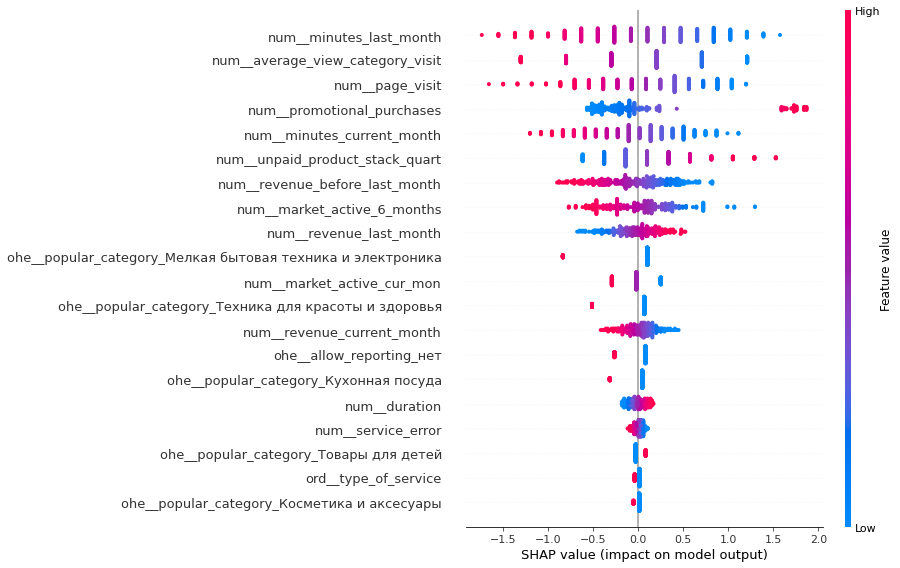

In [89]:
# визуализируем значения SHAP в виде графика
shap.plots.beeswarm(shap_values, max_display = 21) 

Сильнее всего на результат модели влияет признаки "минуты за прошлый месяц", "среднее время просмотра категории", "количество страниц за посещение". Это вполне логично, ведь чем дольше пользователь выбирает как-либо товар, тем больше шанс, что он его приобретет.
С акционными покупками ситуация интереснее: получается, что по акциями чаще пользуются клиенты, которые не являются постоянными покупателями магазина и не становятся таковыми. Так же инетерсная ситуация возникает с выручкой от пользователя за месяц: чем больше прибыли пользователь принес в пердыдущем месяце, тем больше его вероятность того, что его активность снизится, а с остальными параметрами выручки ситуация обратная. Возможно это связано с проведением как-то акции в прошлом месяце.
Кроме того, стоит отметить, что чем больше у пользователя неоплаченых покупок, тем больше шанс того, что его покупательская активность снизится.

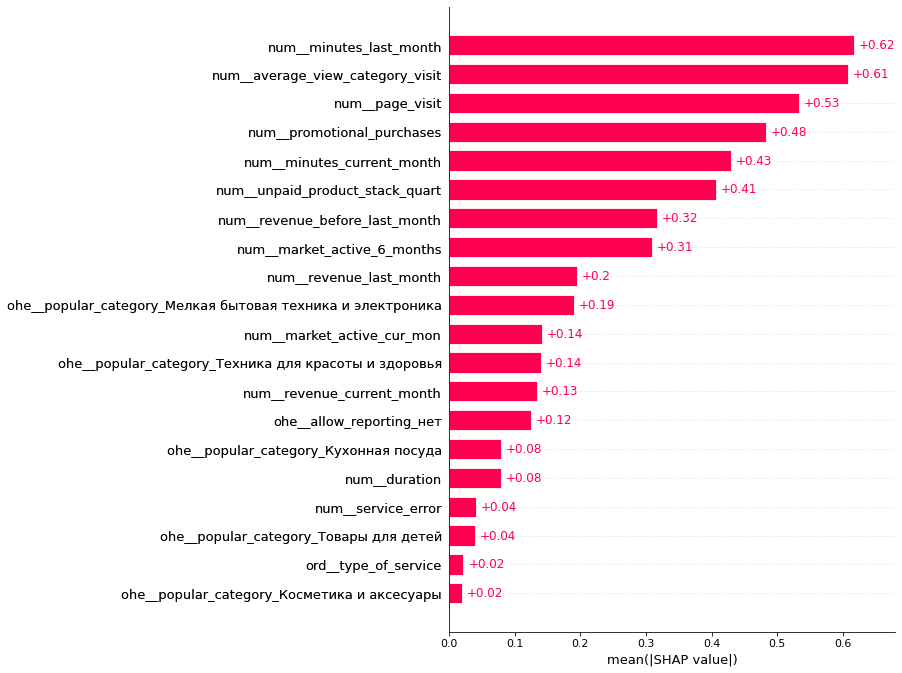

In [90]:
# визуализируем значения SHAP в виде столбчатой диаграммы
shap.plots.bar(shap_values, max_display = 21)

Выводы:

Наиболее значимые признаки: количество страниц за визит, время, проведенное на сайте в предыдущем месяце,  время, проведенное на сайте в текущем месяце, среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца.

Наименее значимые признаки: сервисные ошибки, количество неоплаченных товаров в корзине за последние 3 месяца.

Сильнее всего на результат модели влияет признаки "минуты за прошлый месяц", "среднее время просмотра категории", "количество страниц за посещение". Это вполне логично, ведь чем дольше пользователь выбирает как-либо товар, тем больше шанс, что он его приобретет. С акционными покупками ситуация интереснее: получается, что по акциями чаще пользуются клиенты, которые не являются постоянными покупателями магазина и не становятся таковыми. Так же инетерсная ситуация возникает с выручкой от пользователя за месяц: чем больше прибыли пользователь принес в пердыдущем месяце, тем больше его вероятность того, что его активность снизится, а с остальными параметрами выручки ситуация обратная. Возможно это связано с проведением как-то акции в прошлом месяце. Кроме того, стоит отметить, что чем больше у пользователя неоплаченых покупок, тем больше шанс того, что его покупательская активность снизится.

## Сегментация покупателей

In [91]:
# выполним сегментацию покупателей. Сделаем прогноз их активности и объединим эти данные с данными о прибыли 
predicted = randomized_search.predict(X_test)
X_test['predicted'] = predicted
X_test.reset_index(inplace=True)

In [92]:
data = X_test.sort_values(by='predicted')
data.head()

,id,type_of_service,allow_reporting,market_active_6_months,market_active_cur_mon,duration,promotional_purchases,popular_category,average_view_category_visit,unpaid_product_stack_quart,service_error,page_visit,revenue_last_month,revenue_before_last_month,revenue_current_month,minutes_last_month,minutes_current_month,predicted
0,215950,стандарт,да,3.9,5,827,0.25,Мелкая бытовая техника и электроника,6,1,4,8,5124.5,4415.0,5869.4,11,13,0
184,216154,стандарт,да,3.2,4,320,0.18,Домашний текстиль,5,4,1,8,6160.5,5247.0,7082.2,13,15,0
185,215746,премиум,да,4.4,4,987,0.35,Техника для красоты и здоровья,3,1,8,6,3222.0,4932.0,4169.7,10,9,0
187,216557,стандарт,да,3.9,4,788,0.26,Техника для красоты и здоровья,3,3,7,9,4774.0,5176.0,4555.6,10,17,0
189,215855,стандарт,да,5.5,5,149,0.20,Кухонная посуда,3,2,6,6,5634.5,4682.0,6590.0,21,8,0


In [93]:
segment = X_test.merge(data_money, on = 'id')

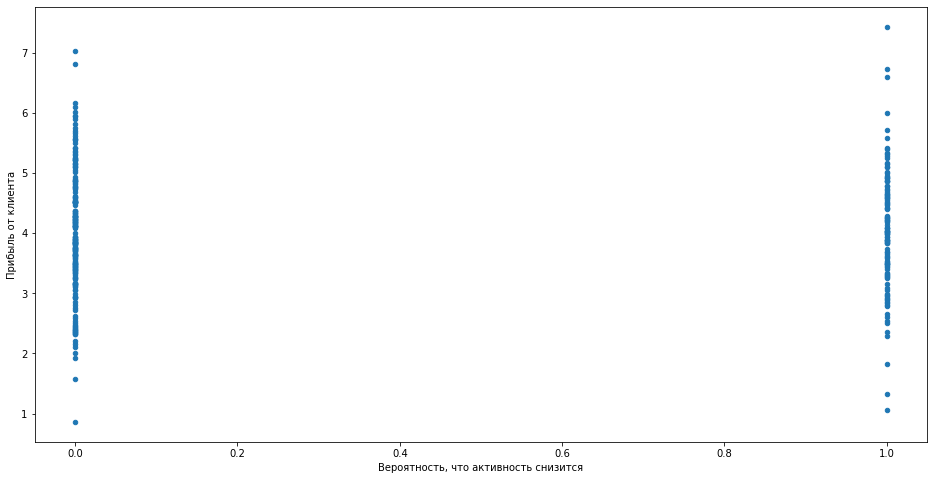

In [94]:
segment.plot.scatter(x = 'predicted', y = 'profit', figsize=(16, 8))
plt.xlabel('Вероятность, что активность снизится')
plt.ylabel('Прибыль от клиента')
plt.show()

In [95]:
# рассмотрим сегмент покупателей, прибыль от которых больше среднего, 
# но у них высокая вероятность снижения активности
segment_1 = segment[(segment['predicted'] == 1) & (segment['profit'] >= segment['profit'].mean())]

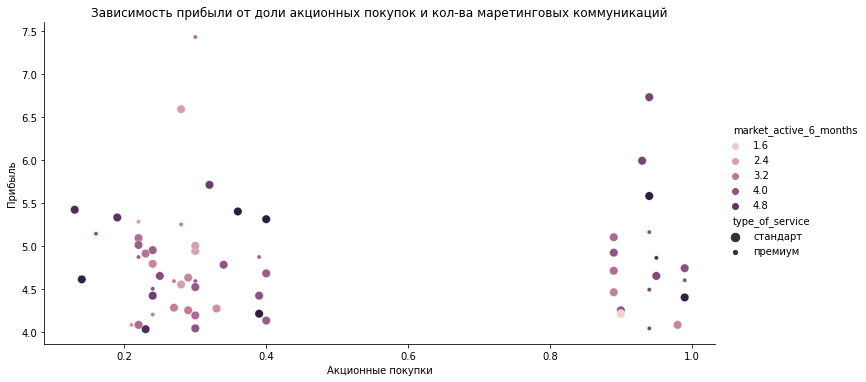

In [96]:
sns.relplot(data = segment_1, x = 'promotional_purchases', y ='profit', hue = 'market_active_6_months', size = 'type_of_service', 
            aspect = 2)
plt.title('Зависимость прибыли от доли акционных покупок и кол-ва маретинговых коммуникаций')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

Клиенты премиум класса мало используют акционные предложения. Прибыль и удержание клиентов не сильно зависят от маркетинговой активности.

In [97]:
segment_1.pivot_table(index = ['page_visit', 'type_of_service'])

average_view_category_visit     duration  \
page_visit type_of_service                                             
1          стандарт                            2.666667   533.000000   
2          премиум                             1.500000   388.500000   
           стандарт                            2.454545   445.818182   
3          премиум                             3.000000   377.000000   
           стандарт                            2.100000   588.000000   
4          премиум                             1.500000   399.500000   
           стандарт                            2.500000   633.500000   
5          премиум                             2.666667   930.666667   
           стандарт                            2.000000   735.000000   
6          премиум                             2.333333   747.333333   
           стандарт                            2.400000   560.800000   
7          премиум                             2.333333   905.000000   
           стандарт                            2.000000   574.500000   
8          премиум                             4.000000   162.000000   
           стандарт                            2.000000   458.500000   
9          стандарт                            4.000000   765.000000   
11         премиум                             3.000000  1032.000000   

                                       id  market_active_6_months  \
page_visit type_of_service                                          
1          стандарт         215488.666667                4.166667   
2          премиум          215609.000000                3.700000   
           стандарт         215574.363636                3.781818   
3          премиум          215417.000000                4.100000   
           стандарт         215534.100000                3.780000   
4          премиум          215560.000000                2.900000   
           стандарт         215536.166667                3.116667   
5          премиум          215593.333333                3.966667   
           стандарт         215531.000000                3.450000   
6          премиум          215556.666667                3.766667   
           стандарт         215642.400000                3.800000   
7          премиум          215661.666667                3.166667   
           стандарт         215899.750000                4.875000   
8          премиум          216622.000000                4.100000   
           стандарт         216585.500000                4.450000   
9          стандарт         216057.000000                5.500000   
11         премиум          216413.000000                5.200000   

                            market_active_cur_mon  minutes_current_month  \
page_visit type_of_service                                                 
1          стандарт                      3.333333               7.333333   
2          премиум                       4.000000               9.000000   
           стандарт                      4.545455               9.454545   
3          премиум                       5.000000               9.000000   
           стандарт                      4.300000              10.000000   
4          премиум                       5.000000               9.500000   
           стандарт                      4.000000               9.166667   
5          премиум                       4.333333              10.333333   
           стандарт                      3.500000              12.000000   
6          премиум                       4.000000               9.000000   
           стандарт                      4.200000               9.200000   
7          премиум                       3.666667               8.333333   
           стандарт                      4.000000              13.000000   
8          премиум                       3.000000               8.000000   
           стандарт                      4.000000              15.500000   
9          стандарт                      4.000000      

Пользователи, посещающие мало страниц за визит, имеют одни из самых наибольших вероятностей на снижение своей активности. 

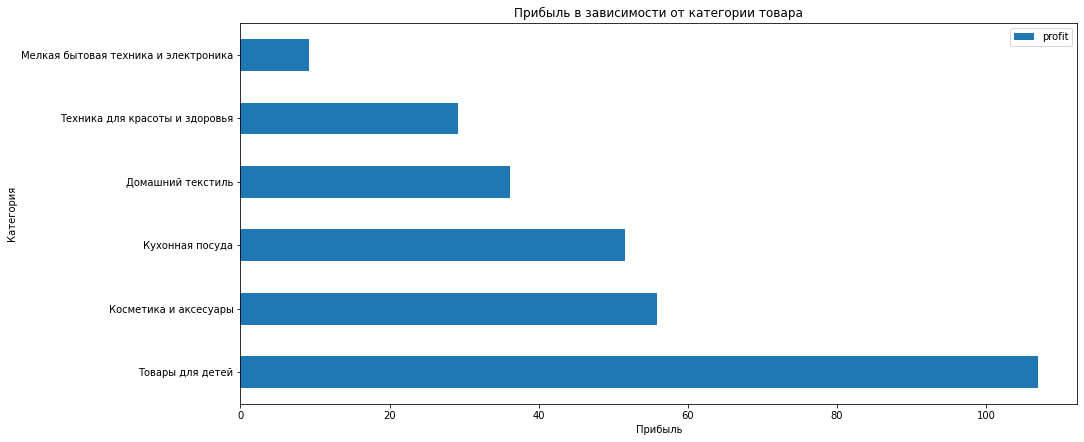

In [98]:
# построим гистограмму, отображающую прибыль в зависимости от категории товара
segment_1.groupby('popular_category')['profit'].sum().sort_values(ascending = False).plot(
    kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Прибыль в зависимости от категории товара')
plt.ylabel('Категория')
plt.xlabel('Прибыль')
plt.show()

Наиболее популярные категории товаров - "Товары для детей" и "Косметика и аксессуары". 

In [99]:
segment_1.pivot_table(index = 'popular_category')

,average_view_category_visit,duration,id,market_active_6_months,market_active_cur_mon,minutes_current_month,minutes_last_month,page_visit,predicted,profit,promotional_purchases,revenue_before_last_month,revenue_current_month,revenue_last_month,service_error,unpaid_product_stack_quart
popular_category,,,,,,,,,,,,,,,,
Домашний текстиль,2.375000,482.750000,215504.625000,3.575000,4.000000,8.125000,10.875000,3.250000,1,4.517500,0.505000,4583.125000,5767.025000,5452.750000,4.375000,4.875000
Косметика и аксесуары,2.181818,703.181818,215649.909091,3.054545,4.181818,9.272727,10.454545,4.818182,1,5.084545,0.382727,4601.000000,5592.227273,5101.181818,4.363636,3.727273
Кухонная посуда,2.090909,659.363636,215673.454545,3.836364,4.181818,10.454545,12.181818,4.909091,1,4.691818,0.474545,4650.909091,5764.581818,5352.363636,3.818182,5.545455
Мелкая бытовая техника и электроника,2.000000,589.500000,216173.500000,5.350000,3.500000,16.000000,13.000000,9.000000,1,4.630000,0.970000,4639.500000,6014.100000,5306.250000,2.500000,3.500000
Техника для красоты и здоровья,2.500000,530.166667,215510.666667,3.816667,4.000000,11.500000,10.666667,3.166667,1,4.851667,0.581667,4606.000000,4421.450000,4455.666667,3.333333,6.666667
Товары для детей,2.545455,551.090909,215711.954545,4.168182,4.227273,9.545455,8.500000,4.090909,1,4.859545,0.434545,4648.636364,5071.909091,4872.181818,3.681818,3.227273


Доли акционных покупок в категориях "Товары для детей" и "Косметика и аксессуары" одни из самых низких. 

In [100]:
# теперь выберем контрсегмент: выгодные для компании клиенты, но для которых модель предсказывает другое поведение
segment_2 = segment[(segment['predicted'] == 0) & (segment['profit'] >= segment['profit'].mean())]

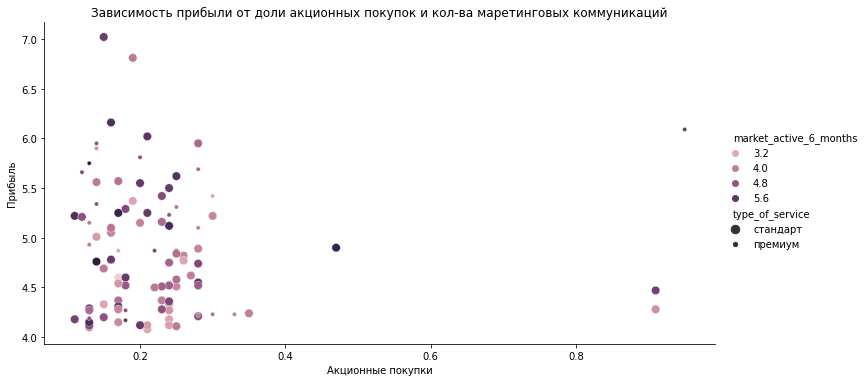

In [101]:
sns.relplot(data = segment_2, x = 'promotional_purchases', y ='profit', hue = 'market_active_6_months', size = 'type_of_service', 
            aspect = 2)
plt.title('Зависимость прибыли от доли акционных покупок и кол-ва маретинговых коммуникаций')
plt.xlabel('Акционные покупки')
plt.ylabel('Прибыль')
plt.show()

Прибыль и удержание клиентов не сильно зависят от маркетинговой активности.

In [102]:
segment_2.pivot_table(index = ['page_visit', 'type_of_service'])

average_view_category_visit     duration  \
page_visit type_of_service                                             
3          премиум                             4.000000   570.000000   
           стандарт                            3.000000   621.333333   
4          стандарт                            3.000000   693.000000   
5          премиум                             4.000000   728.000000   
           стандарт                            3.333333   456.333333   
6          премиум                             3.000000   699.000000   
           стандарт                            3.666667   433.666667   
7          премиум                             3.000000   828.000000   
           стандарт                            3.333333   439.222222   
8          премиум                             2.500000   422.500000   
           стандарт                            4.500000   431.833333   
9          премиум                             2.750000   696.000000   
           стандарт                            3.125000   684.750000   
10         премиум                             4.000000   524.333333   
           стандарт                            4.000000   490.333333   
11         премиум                             4.500000   911.000000   
           стандарт                            4.166667   522.166667   
12         премиум                             2.666667   661.333333   
           стандарт                            4.111111   552.888889   
13         премиум                             4.666667   582.333333   
           стандарт                            4.666667   501.666667   
14         стандарт                            3.666667   314.666667   
15         стандарт                            5.000000   595.000000   
16         премиум                             3.000000   835.000000   
           стандарт                            4.000000   577.000000   
17         премиум                             4.000000   899.000000   
           стандарт                            2.000000   205.000000   
18         стандарт                            4.000000   622.000000   
19         стандарт                            3.000000  1001.000000   

                                       id  market_active_6_months  \
page_visit type_of_service                                          
3          премиум          216031.000000                4.900000   
           стандарт         216187.333333                4.933333   
4          стандарт         216238.000000                4.000000   
5          премиум          215780.000000                4.100000   
           стандарт         216115.000000                4.533333   
6          премиум          216107.000000                4.000000   
           стандарт         216235.111111                4.655556   
7          премиум          216074.000000                3.700000   
           стандарт         216150.666667                4.344444   
8          премиум          216285.500000                4.050000   
           стандарт         216265.666667                3.883333   
9          премиум          216124.500000                5.025000   
           стандарт         216231.250000                4.525000   
10         премиум          216122.000000                4.600000   
           стандарт         216100.500000                4.633333   
11         премиум          216078.000000                5.300000   
           стандарт         216158.333333                4.400000   
12         премиум          216050.666667                4.800000   
           стандарт         216199.222222                4.466667   
13         премиум          216232.000000                4.400000   
           стандарт         215960.666667                4.883333   
14         стандарт         216296.333333                5.033333   
15         стандарт         216507.000000                3.700000   
16         премиум          216358.000000                4.100000   
 

Пользователи, у которых не прогнозируется снижение активности, посещают много страниц.

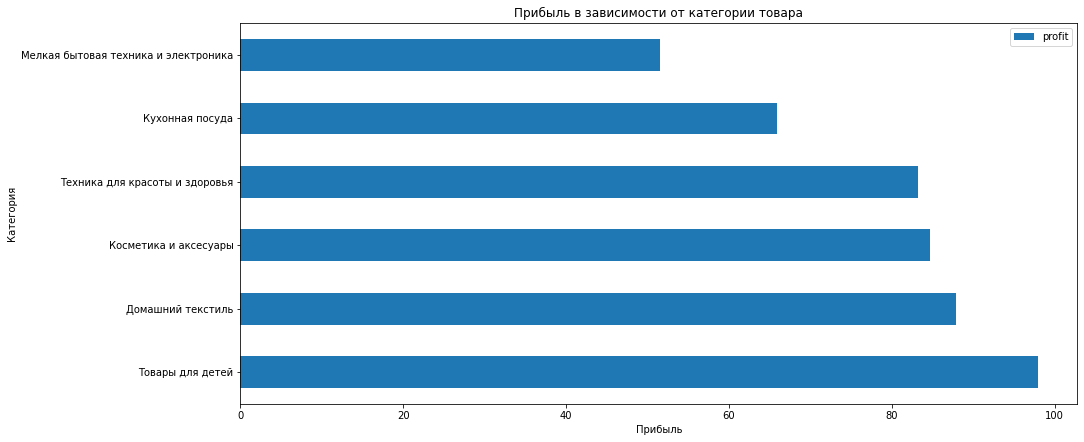

In [103]:
# построим гистограмму, отображающую прибыль в зависимости от категории товара
segment_2.groupby('popular_category')['profit'].sum().sort_values(ascending = False).plot(
    kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Прибыль в зависимости от категории товара')
plt.ylabel('Категория')
plt.xlabel('Прибыль')
plt.show()

Популярные категории у клиентов: товары для детей и домашний текстиль.

In [104]:
segment_2.pivot_table(index = 'popular_category')

,average_view_category_visit,duration,id,market_active_6_months,market_active_cur_mon,minutes_current_month,minutes_last_month,page_visit,predicted,profit,promotional_purchases,revenue_before_last_month,revenue_current_month,revenue_last_month,service_error,unpaid_product_stack_quart
popular_category,,,,,,,,,,,,,,,,
Домашний текстиль,3.944444,535.166667,216052.166667,4.611111,3.888889,15.388889,16.055556,10.833333,0,4.885000,0.222778,4987.388889,4762.372222,4798.194444,4.555556,2.722222
Косметика и аксесуары,3.764706,549.764706,216136.529412,4.752941,4.058824,17.058824,14.882353,8.000000,0,4.979412,0.204706,5051.117647,5521.400000,5233.411765,4.117647,1.882353
Кухонная посуда,3.142857,515.857143,216276.214286,4.535714,4.357143,14.928571,17.071429,8.642857,0,4.704286,0.196429,5111.214286,5570.600000,5188.678571,4.714286,2.214286
Мелкая бытовая техника и электроника,3.363636,621.545455,216158.818182,4.172727,4.272727,14.454545,14.272727,8.272727,0,4.690000,0.204545,4879.636364,5297.436364,5016.636364,4.909091,2.090909
Техника для красоты и здоровья,4.117647,582.705882,216256.764706,4.452941,4.176471,16.000000,14.588235,10.294118,0,4.894118,0.298824,4969.470588,4860.594118,4611.911765,3.941176,1.529412
Товары для детей,3.700000,511.300000,216165.950000,4.650000,4.000000,14.950000,14.500000,10.950000,0,4.896000,0.235000,4937.350000,5007.655000,4488.500000,4.000000,2.950000


Доли акционных покупок во всех категориях гораздо ниже, чем в первом сегменте.

Выводы:

Были рассмотрены сегмент покупателей, прибыль от которых больше среднего, но у которых согласно нашим прогнозам высокая вероятность снижения активности (больше 0.7) и сегмент покупателей, прибыль от которых больше среднего, но у которых согласно нашим прогнозам высокая вероятность сохранения активности (меньше 0.7)

Пользователи, посещающие мало страниц за визит, имеют одни из самых наибольших вероятностей на снижение своей активности. Клиенты премиум класса их рассмотренного сегмента мало используют акционные предложения. Прибыль и удержание клиентов не сильно зависит от маркетинговой активности. Наиболее популярные категории товаров - "Товары для детей" и "Косметика и аксессуары". Но доли акционных покупок в этих категориях одни из самых низких. "Верные" клиенты посещают много страниц сайта и не часто используют акционные предложения. 

Рекомендации, которую можно дать:
стоит изменить маркетинговую активность, продумать стратегию удержания внимания клиентов на сайте (внешний вид сайта, рекомендации покупок исходя из просмотренных страниц или уже сделанных покупок). 


## Выводы

В рамках данного проекта предстоит разработать решение, которое позволит персонализировать предложения постоянным клиентам интернет-магазина «В один клик», чтобы увеличить их покупательскую активность.

На первом этапе работы были изучены данные. В датафрейме data_market 1300 записей, названия столбцов адекватны содержащимся в них данным, но введены на кириллице, в столбцах id, Маркет_актив_тек_мес, Длительность, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Ошибка_сервиса, Страниц_за_визит тип данных int, в столбцах Покупательская активность, Тип сервиса, Разрешить сообщать, Популярная_категория тип данных object, в столбцах Маркет_актив6мес, Акционные_покупки тип данных float. В датафрейме data_market_money 3900 записи, названия столбцов адекватны содержащимся в них данным, но введены на кириллице, в столбцах id тип данных int, в столбце Период тип данных object, в столбце Выручка float. В датафрейме data_time 2600 записей, названия столбцов адекватны содержащимся в них данным, но введены на кириллице, в столбцах id тип данных int, в столбце Период тип данных object, в столбце минут float. В датафрейме data_money 1300 записей, названия столбцов адекватны содержащимся в них данным, но введены на кириллице, в столбцах id тип данных int, в столбце Прибыль float. Требовалась коректировка названий столбцов и предобработка данных (проверка наличия пропусков и дубликатов).

На этапе предобработки данных были изменены названия столбцов; проверено, нет ли пропущенных значений; были удалены явные дубликаты.

Был проведен исследовательский анализ данных. Выяснилось, что у 38% id снизилась покупательская активность. У 71% id - тип сервиса "стандарт". 74% id разрешают сообщать информацию о том, можно ли присылать покупателю дополнительные предложения о товаре. Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, находятся в диапазоне от 0.9 до 6.6, медиана - 4.2.Количество маркетинговых коммуникаций в текущем месяце - 4 у 52%, 5 у 25% и 3 у 24%. Показатели активности рынка находятся в диапазоне от 110 до 1079, медиана - 607. Показатели активности рынка находятся в диапазоне от 0 до 0.99, медиана - 0.24. Популярные категории: товары для детей (26%), домашний текстиль (19%), косметика и аксесуары (17%), техника для красоты и здоровья (14%), мелкая бытовая техника и электроника (14%), кухонная посуда (11%). Средний просмотр категорий за визит: 3 (27%), 2 (24%), 4 (21%). Общее число неоплаченных товаров в корзине за последние 3 месяца - от 0 до 10, медиана - 2. Число сбоев, которые коснулись покупателя во время посещения сайта, - от 0 до 9, медиана - 4. Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. - от 1 до 20, медиана - 8. Сумма выручки за период от 0 до 7799, медиана - 4959.. 67% выручки получено в предыдущем месяце и 33% - в текущем. Значение времени, проведённого на сайте, в минутах - от 4 до 23, медиана - 13. Периоды, во время которых зафискировано общее время, - 50% в текущем месяце и 50% в предыдущем. Значение прибыли за последние 3 месяца - от 0.86 до 7.43, медиана - 4.04.

Данные из всех датасетов были объединены в одну таблицу.

Корреляционный анализ выявил высокую корреляцию у покупательской активности с количеством посещенных страниц (0.75), минутами за последний месяц (0.68). 

Были созданы пайплайны для выбора лучшей модели для прогнозирования активности клиентов. Лучшая модель - LogisticRegression(C=11, random_state=42), значение метрики roc_auc - 0.9.


Наиболее значимые признаки: количество страниц за визит, время, проведенное на сайте в предыдущем месяце,  время, проведенное на сайте в текущем месяце, среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца.

Наименее значимые признаки: сервисные ошибки, количество неоплаченных товаров в корзине за последние 3 месяца.

Сильнее всего на результат модели влияет признаки "минуты за прошлый месяц", "среднее время просмотра категории", "количество страниц за посещение". Это вполне логично, ведь чем дольше пользователь выбирает как-либо товар, тем больше шанс, что он его приобретет. С акционными покупками ситуация интереснее: получается, что по акциями чаще пользуются клиенты, которые не являются постоянными покупателями магазина и не становятся таковыми. Так же инетерсная ситуация возникает с выручкой от пользователя за месяц: чем больше прибыли пользователь принес в пердыдущем месяце, тем больше его вероятность того, что его активность снизится, а с остальными параметрами выручки ситуация обратная. Возможно это связано с проведением как-то акции в прошлом месяце. Кроме того, стоит отметить, что чем больше у пользователя неоплаченых покупок, тем больше шанс того, что его покупательская активность снизится.
Отдельно был рассмотрен сегмент покупателей, прибыль от которых больше среднего, но у которых согласно нашим прогнозам высокая вероятность снижения активности (больше 0.7). Пользователи, посещающие мало страниц за визит, имеют одни из самых наибольших вероятностей на снижение своей активности. Клиенты премиум класса их рассмотренного сегмента мало используют акционные предложения. Прибыль и удержание клиентов не сильно зависит от маркетинговой активности. Наиболее популярные категории товаров - "Товары для детей" и "Косметика и аксессуары". Но доли акционных покупок в этих категориях одни из самых низких."Верные" клиенты посещают много страниц сайта и не часто используют акционные предложения. 

В результате проделанной работы можно дать следующие рекомендации: стоит изменить маркетинговую активность, продумать стратегию удержания внимания клиентов на сайте (внешний вид сайта, рекомендации покупок исходя из просмотренных страниц или уже сделанных покупок). 